<img align="center" style="max-width: 1000px" src="figures/banner.png">

<img align="right" style="max-width: 200px; height: auto" src="figures/hsg_logo.png">

##  Lab 03 - "Multi-Layer Perceptrons"

Machine Learning, University of St. Gallen, Spring Term 2023

In this lab, we will learn how to implement, train, and evaluate a Multi-Layer Perceptron (MLP) using `PyTorch`. We will use the implemented neural network to learn to again classify images of fashion articles from the **Fashion-MNIST** dataset.

Objectives:

1. Implement and train an MLP to **classify images**.
2. **Evaluate and interpret results** of the network.

# 1. Problem Definition

#### 1.1 Dataset

The **Fashion-MNIST database** is a large database of Zalando articles that is commonly used for training various image processing systems. The database is widely used for training and testing in the field of machine learning. Let's have a brief look into a couple of sample images contained in the dataset:

The dataset consists of 70,000 images. It is divided into a set of **60,000 training examples** and a set of **10,000 evaluation examples**. Each example is a **28x28 grayscale image**, associated with a **label from 10 classes**. Zalando created this dataset with the intention of providing a replacement for the popular **MNIST** handwritten digits dataset. It is a useful addition as it is a bit more complex, but still very easy to use. It shares the same image size and train/test split structure as MNIST, and can therefore be used as a drop-in replacement. It requires minimal efforts on preprocessing and formatting the distinct images.

<img align="center" style="max-width: 700px; height: 300px" src="figures/FashionMNIST.png">

Source: https://www.kaggle.com/c/insar-fashion-mnist-challenge

#### 1.2 Model

The figure below illustrates a high-level view of the machine learning process we aim to establish in this lab:

<img align="center" style="max-width: 700px" src="figures/classification.png">

The neural network, which we name **'FashionMNISTNet'** consists of three **fully-connected layers** (including an “input layer” and two hidden layers). Furthermore, the **FashionMNISTNet** should encompass the following number of neurons per layer: 100 (layer 1), 50 (layer 2) and 10 (layer 3). Meaning the first layer consists of 100 neurons, the second layer of 50 neurons and third layer of 10 neurons (the number of digit classes we aim to classify).

Further details on the dataset can be obtained via Zalando research's [github page](https://github.com/zalandoresearch/fashion-mnist).

# 2. Implementation

#### 2.1 Download and Prepare dataset

In [1]:
import torchvision

In [2]:
# Define pytorch transformation to convert dataset samples to PyTorch tensors
transf = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

# Download and initialize train set
train_set = torchvision.datasets.FashionMNIST(root="./data", train=True, transform=transf, download=True)
test_set = torchvision.datasets.FashionMNIST(root="./data", train=False, transform=transf, download=True)

#### 2.2 Neural Network Implementation

In this section, we will implement the architecture of the **MLP** we aim to utilize for the classification of FashionMNIST images. However, before we start the implementation let's briefly revisit the process to be established. The following figure provides a birds-eye view:

<img align="center" style="max-width: 1000px" src="https://github.com/HSG-AIML/LabGSERM/blob/main/lab_04/process.png?raw=1">

We will now start implementing the network architecture as a separate Python class. Implementing the network architectures as a **separate class** in Python is good practice in deep learning projects. It will allow us to create and train several instances of the same neural network architecture. This provides us, for example, the opportunity to evaluate different initializations of the network parameters or train models using distinct datasets. 

In [3]:
import torch
import torch.nn as nn

In [4]:
class FashionMNISTNet(nn.Module):
    # Define the class constructor
    def __init__(self):
        # Call super class constructor
        super(FashionMNISTNet, self).__init__()
        
        # Fully-Connected (fc) layer 1 - in 28*28, out 100
        self.linear1 = nn.Linear(28*28, 100, bias=True) # the linearity W*x+b
        self.relu1 = nn.ReLU(inplace=True) # the non-linearity 
        
        # FC layer 2 - in 100, out 50
        self.linear2 = nn.Linear(100, 50, bias=True) # the linearity W*x+b
        self.relu2 = nn.ReLU(inplace=True) # the non-linarity
        
        # FC layer 3 - in 50, out 10
        self.linear3 = nn.Linear(50, 10) # the linearity W*x+b
        
        # Softmax for the last layer
        self.softmax = nn.Softmax(dim=1) # the softmax
        
    # Define network forward pass
    def forward(self, images):
        
        # Reshape image pixels
        x = images.view(-1, 28*28)
        
        # FC layer 1 forward pass
        x = self.relu1(self.linear1(x))
        
        # FC layer 2 forward pass
        x = self.relu2(self.linear2(x))
        
        # FC layer 3 forward pass
        x = self.softmax(self.linear3(x))
        
        return x

The output of the softmax describes the probability (or if you may, the confidence) of the neural network that a particular sample belongs to a certain class. Thus, for the first example above, the neural network assigns a confidence of 0.49 that it is a 'three', 0.49 that it is a 'four', and 0.03 that it is an 'eight'. The same goes for each of the samples above.

<img align="center" style="max-width: 800px" src="figures/softmax.png">

Now, that we have implemented our first neural network we are ready to instantiate a network model to be trained:

In [5]:
model = FashionMNISTNet()

Let's push the initialized `FashionMNISTNet` model to the computing `device` that is enabled:

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Send model to compute device
model.to(device)

FashionMNISTNet(
  (linear1): Linear(in_features=784, out_features=100, bias=True)
  (relu1): ReLU(inplace=True)
  (linear2): Linear(in_features=100, out_features=50, bias=True)
  (relu2): ReLU(inplace=True)
  (linear3): Linear(in_features=50, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)

# 3. Training

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

Furthermore, lets specify and instantiate a corresponding PyTorch data loader that feeds the image tensors to our neural network:

In [8]:
batch_size = 128 # Size of the mini-batches

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

Based on the loss magnitude of a certain mini-batch PyTorch automatically computes the gradients. But even better, based on the gradient, the library also helps us in the optimization and update of the network parameters $\theta$.

We will use the **Stochastic Gradient Descent (SGD)** algorithm for the optimization with learning-rate $l = 0.001$. Each mini-batch step the optimizer will update the model parameters $\theta$ values according to the degree of classification error.

In [9]:
# Define learning rate and the optimization algorithm
learning_rate = 0.001
optimizer = torch.optim.SGD(params=model.parameters(), lr=learning_rate)

Define Optimization criterion: Cross-Entropy loss function

In [10]:
# Define the optimization criterion / loss function
cross_entropy = nn.CrossEntropyLoss()

And finally the model for multiple epochs:

<img align="center" style="max-width: 350px" src="figures/sgd_alg.png">

In [11]:
# A list to keep epoch losses (for visualization)
train_epoch_losses = []

# Set the model in training mode
model.train()

# Specify the training parameters
num_epochs = 2 # Number of training epochs

# For each epoch in the training
for epoch in range(num_epochs):
    
    # Temp list to keep batch losses
    train_mini_batch_losses = []
    
    # For each batch in the dataloader
    for i, (x, y) in enumerate(train_loader):
        
        # Push mini-batch data to compute device
        x, y = x.to(device), y.to(device)
        
        # Model forward
        pred = model(x)
        
        # Reset model's gradients
        model.zero_grad()
        
        # Calculate loss for the current batch
        loss = cross_entropy(pred, y)
        
        # Backprop
        loss.backward()
        
        # Update network paramaters
        optimizer.step()
        
        # Collect mini-batch losses
        train_mini_batch_losses.append(loss.data.item())
    
    # Calculate epoch loss
    avg_epoch_loss = np.mean(train_mini_batch_losses)
    
    # Store A mean min-batch  loss of epoch
    train_epoch_losses.append(avg_epoch_loss)
    
    print(f"Epoch {epoch}: {avg_epoch_loss}")
    
# Save the checkpoint of the model after the final epoch
torch.save(model.state_dict(), "./checkpoint.pt")
    

Epoch 0: 2.3027943751451048
Epoch 1: 2.302423880806864


Upon successfull training let's visualize and inspect the training loss per epoch:

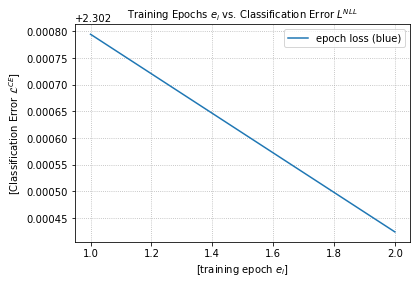

In [12]:
# Prepare plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Add grid
ax.grid(linestyle='dotted')

# Plot the training epochs vs. the epochs' classification error
ax.plot(np.array(range(1, len(train_epoch_losses)+1)), train_epoch_losses, label='epoch loss (blue)')

# Add axis legends
ax.set_xlabel("[training epoch $e_i$]", fontsize=10)
ax.set_ylabel("[Classification Error $\mathcal{L}^{CE}$]", fontsize=10)

# Set plot legend
plt.legend(loc="upper right", numpoints=1, fancybox=True)

# Add plot title
plt.title('Training Epochs $e_i$ vs. Classification Error $L^{NLL}$', fontsize=10);

Ok, fantastic. The training error is nicely going down. We could train the network a couple more epochs until the error converges. But let's stay with the 20 training epochs for now and continue with evaluating our trained model.

# 4. Evaluation

In [13]:
import seaborn as sns

# import sklearn classification evaluation library
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

Load the checkpoint from trained model:

In [14]:
# Load state_dict from path
state_dict = torch.load("checkpoint.pt")

# Init pre-trained model class
best_model = FashionMNISTNet()

# Load pre-trained state_dict to the model
best_model.load_state_dict(state_dict)

<All keys matched successfully>

Enable evaluation mode in the model. It is necessary to enable evaluation mode since some models have modules that can bahave differently in the train and evaluation mode. Example: batch-normalization layers.

In [15]:
# set model in evaluation mode
best_model.eval()

FashionMNISTNet(
  (linear1): Linear(in_features=784, out_features=100, bias=True)
  (relu1): ReLU(inplace=True)
  (linear2): Linear(in_features=100, out_features=50, bias=True)
  (relu2): ReLU(inplace=True)
  (linear3): Linear(in_features=50, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)

To evaluate our trained model, we need to feed the FashionMNIST images reserved for evaluation (the images that we didn't use as part of the training process) through the model. Therefore, let's again define a corresponding PyTorch data loader that feeds the image tensors to our neural network: 

In [16]:
# Test loader
test_loader = DataLoader(test_set, batch_size=64)

We will now evaluate the trained model using the same mini-batch approach as we did throughout the network training and derive the mean negative log-likelihood loss of the mini-batches:

In [17]:
# init collection of mini-batch losses
eval_mini_batch_losses = []

# iterate over all-mini batches
for i, (images, labels) in enumerate(test_loader):

    # run forward pass through the network
    output = best_model(images)

    # determine classification loss
    loss = cross_entropy(output, labels)

    # collect mini-batch reconstruction loss
    eval_mini_batch_losses.append(loss.data.item())

# determine mean min-batch loss of epoch
eval_loss = np.mean(eval_mini_batch_losses)


In [18]:
eval_loss

2.3022444475987913

Ok, great. The evaluation loss looks in-line with our training loss. Let's now inspect a few sample predictions to get an impression of the model quality. Therefore, we will again pick a random image of our evaluation dataset and retrieve its PyTorch tensor as well as the corresponding label:

In [19]:
# set (random) image id
image_id = 2000

# retrieve image exhibiting the image id
fashion_mnist_eval_image, fashion_mnist_eval_label = test_set[image_id]

Let's now inspect the true class of the image we selected:

In [20]:
fashion_classes = {0: 'T-shirt/top',
                    1: 'Trouser',
                    2: 'Pullover',
                    3: 'Dress',
                    4: 'Coat',
                    5: 'Sandal',
                    6: 'Shirt',
                    7: 'Sneaker',
                    8: 'Bag',
                    9: 'Ankle boot'}

In [21]:
fashion_classes[fashion_mnist_eval_label]

'Bag'

Ok, the randomly selected image should contain a bag. Let's inspect the image accordingly:

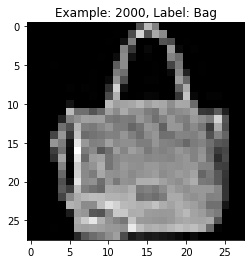

In [22]:
# define tensor to image transformation
trans = torchvision.transforms.ToPILImage()

# set image plot title 
plt.title('Example: {}, Label: {}'.format(str(image_id), fashion_classes[fashion_mnist_eval_label]))

# plot mnist handwritten digit sample
plt.imshow(trans(fashion_mnist_eval_image), cmap='gray')

Let's compare the true label with the prediction of our model:

We can even determine the likelihood of the most probable class:

In [23]:
most_probable = torch.argmax(best_model(fashion_mnist_eval_image), dim=1).item()
print('Most probable class: {}'.format(most_probable))
print('This class represents the following fashion article: {}'.format(fashion_classes[most_probable]))

Most probable class: 1
This class represents the following fashion article: Trouser


Let's now obtain the predictions for all the fashion item images of the evaluation data:

In [24]:
predictions = torch.argmax(best_model(test_set.data.float()), dim=1)

Furthermore, let's obtain the overall classifcation accuracy:

In [25]:
metrics.accuracy_score(test_set.targets, predictions.detach())

0.1925

Let's also inspect the confusion matrix to determine major sources of misclassification:

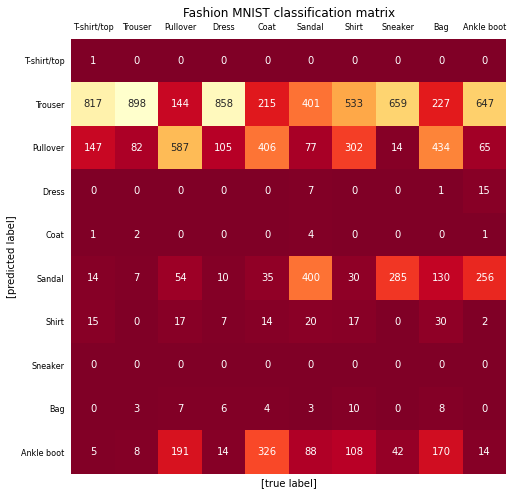

In [26]:
# determine classification matrix of the predicted and target classes
mat = confusion_matrix(test_set.targets, predictions.detach())

# initialize the plot and define size
plt.figure(figsize=(8, 8))

# plot corresponding confusion matrix
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='YlOrRd_r', xticklabels=fashion_classes.values(), yticklabels=fashion_classes.values())
plt.tick_params(axis='both', which='major', labelsize=8, labelbottom = False, bottom=False, top = False, left = False, labeltop=True)

# set plot title
plt.title('Fashion MNIST classification matrix')

# set axis labels
plt.xlabel('[true label]')
plt.ylabel('[predicted label]');

Ok, we can easily see that our current model confuses sandals with either sneakers or ankle boots. However, the inverse does not really hold. The model sometimes confuses sneakers with ankle boots, and only very rarely with sandals. The same holds ankle boots. Our model also has issues distinguishing shirts from coats (and, to a lesser degree, from T-shirts and pullovers).

These mistakes are not very surprising, as these items exhibit a high similarity.